### Demo notebook for GrounDiT

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import json
from functools import partial
from tqdm import tqdm
import torch
from diffusers.utils.torch_utils import randn_tensor

from groundit.pipeline_groundit import ASPECT_RATIO_512_BIN
from groundit.utils import *

device = torch.device("cuda:0")

### Load GrounDiT model (based on PixArt-$\alpha$)

In [ ]:
# Set model configs
hw_bin = ASPECT_RATIO_512_BIN
model_id = "PixArt-alpha/PixArt-XL-2-512x512"

# Load GrounDiT model
pipe, tokenizer = load_groundit_model(model_id, device)

### Set text prompt and bounding box conditions

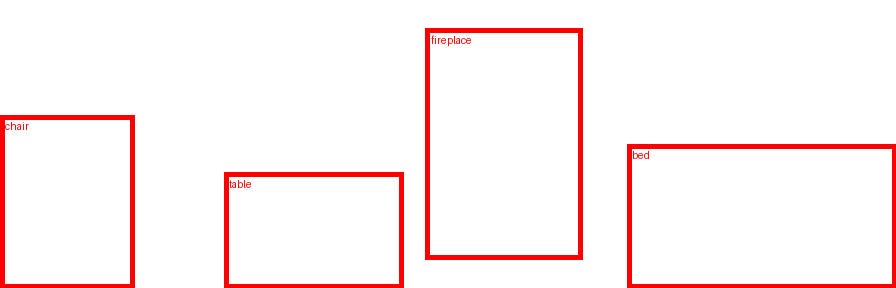

In [4]:
# Text and bounding box conditions for GrounDiT
# NOTE: Change the prompt and phrases to generate different images!
data = {
    "prompt": "a wide view picture of an antique living room with a chair, table, fireplace, and a bed",
    "phrases": ["chair", "table", "fireplace", "bed"],
    "bboxes": [[[0.0, 0.4, 0.15, 1.0]], [[0.25, 0.6, 0.45, 1.0]], [[0.475, 0.1, 0.65, 0.9]], [[0.7, 0.5, 1.0, 1.0]]],
    "height": 288,
    "width": 896
}

# Set seed
seed = 67

# Visualize bounding boxes
bbox_image = Image.new("RGB", (data["width"], data["height"]), (255, 255, 255))
draw_box(
    bbox_image, data["bboxes"], ";".join(data["phrases"]), 
    height=data["height"], width=data["width"]
)
bbox_image

### Generate image with GrounDiT!

[0.0, 0.4, 0.15, 1.0]
[0.25, 0.6, 0.45, 1.0]
[0.475, 0.1, 0.65, 0.9]
[0.7, 0.5, 1.0, 1.0]


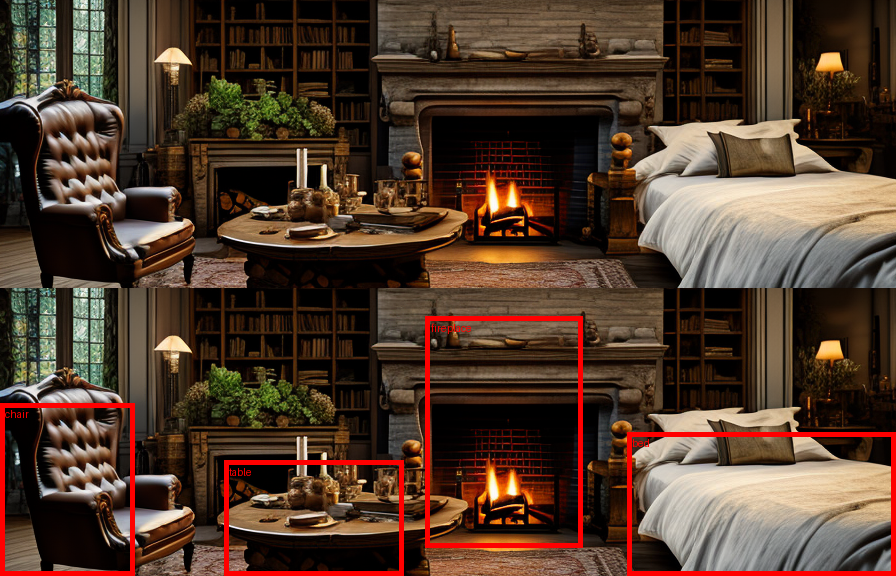

In [5]:
prompt = data["prompt"]
phrases = data["phrases"]
bboxes = data["bboxes"]

bbox_list = sanity_check(bboxes, phrases)

# Find the location of phrase indices in the prompt after tokenization, do it for all pharse in phrases list.
phrases_idx = get_phrases_idx_in_prompt(prompt, phrases, tokenizer)

# Convert bbox coordinates to pixel & latent & patch space. Get the indices of the patches in the patch space that are covered by the bounding box.
# Here boundnig box region corresponds to "Local Patch" in the paper. See Figure 2.
if 'height' in data and 'width' in data:
    original_height, original_width = data['height'], data['width']
    target_height, target_width = pipe.classify_height_width_bin(original_height, original_width, hw_bin)
elif 'aspect_ratio' in data:
    target_height, target_width = pipe.classify_aspect_ratio_bin(data['aspect_ratio'], hw_bin)
    original_height, original_width = target_height, target_width
else:
    raise ValueError("Invalid data format. Need to provide either height/width or aspect_ratio.")

# Set bbox coordinates in pixel space and latent space
latent_height, latent_width = target_height // pipe.vae_scale_factor, target_width // pipe.vae_scale_factor
all_bbox_coord_in_pixel_space = get_bbox_coord_in_pixel_space(bbox_list, target_height, target_width)
all_bbox_coord_in_latent_space = get_bbox_coord_in_latent_space(bbox_list, latent_height, latent_width)

# Get the "Object Image" height and width in pixel space, where "Object Image" is introduced in the paper. See Figure 2.
object_image_hw_in_pixel_space = get_bbox_region_hw(all_bbox_coord_in_pixel_space, hw_bin_classify_func=partial(pipe.classify_height_width_bin, ratios=hw_bin))

# Set seed
seed_everything(seed)
generator = torch.Generator(device=device).manual_seed(seed)

# Main image latent
latent_shape = (1, 4, latent_height, latent_width)
latent = randn_tensor(latent_shape, generator=generator, device=device, dtype=torch.float16) * pipe.scheduler.init_noise_sigma

# Object images latents
object_image_latents_list = list()
for object_image_hw_list in object_image_hw_in_pixel_space:
    object_image_latents_list_for_each_phrase = list()
    for object_image_hw in object_image_hw_list:
        object_image_latents_shape = (1, 4, object_image_hw[0] // pipe.vae_scale_factor, object_image_hw[1] // pipe.vae_scale_factor)
        object_image_latents = randn_tensor(object_image_latents_shape, generator=generator, device=device, dtype=torch.float16) * pipe.scheduler.init_noise_sigma
        object_image_latents_list_for_each_phrase.append(object_image_latents)

    object_image_latents_list.append(object_image_latents_list_for_each_phrase)

# Generate sample
image = pipe(
    prompt=prompt, 
    width=original_width, 
    height=original_height, 
    latents=latent, 
    # General Arguments
    bbox_list=bbox_list, 
    phrases=phrases, 
    phrases_idx=phrases_idx, 
    # Local Update Config
    object_image_latents_list=object_image_latents_list,
    object_image_hw_in_pixel_space=object_image_hw_in_pixel_space,
    all_bbox_coord_in_latent_space=all_bbox_coord_in_latent_space
)[0][0]

# Save the generated samples
image_with_bbox = image.copy()
draw_box(
    image_with_bbox, bbox_list, ";".join(phrases), 
    original_height, original_width
)

# Concat
concat_image = image_grid([image, image_with_bbox], 2, 1)
concat_image